In [1]:
import open3d as o3d
import numpy as np
import os
import glob
import pandas as pd
import pymeshlab as pml
import time
import matplotlib as plt

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
def o3d_to_pml(mesh):
    tmp_file_name = "temp.obj"
    o3d.io.write_triangle_mesh(tmp_file_name, mesh)
    # if not os.path.exists(tmp_file_name):
    #     print(f"File '{tmp_file_name}' doesn't exist. Waiting for 1 second...")
    #     time.sleep(1)    
    mesh_pml = pml.MeshSet()
    mesh_pml.load_new_mesh(tmp_file_name)
    os.remove(tmp_file_name)
    return mesh_pml

In [3]:
def pml_to_o3d(mesh):
    tmp_file_name = "temp.obj"

    mesh.save_current_mesh(tmp_file_name)
    # if not os.path.exists(tmp_file_name):
    #     print(f"File '{tmp_file_name}' doesn't exist. Waiting for 1 second...")
    #     time.sleep(1)   
    mesh_o3d = o3d.io.read_triangle_mesh(tmp_file_name)
    os.remove(tmp_file_name)
    return mesh_o3d

Start building a simple tool that checks all shapes in the database. The tool should output, for each shape

-   the class of the shape
-   the number of faces and vertices of the shape
-   the type of faces (e.g. only triangles, only quads, mixes of triangles and quads)
-   the axis-aligned 3D bounding box of the shapes

In [83]:
def compare_mesh(obj_file_path, offset=(0,0,0), db1="./database/", db2 = "./resampled4/", vis_option = "wireframe_on_shaded"):   
        
        
        mesh = o3d.io.read_triangle_mesh(db1 + obj_file_path.split('/')[2])       
        mesh2 = o3d.io.read_triangle_mesh(db2 + obj_file_path.split('/')[2])
        mesh2.translate(offset)
            
        mesh.compute_vertex_normals() 
        if vis_option == "smoothshade":
            o3d.visualization.draw_geometries([mesh, mesh2], width=1280, height=720)
        elif vis_option == "wireframe_on_shaded":
            o3d.visualization.draw_geometries([mesh, mesh2], width=1280, height=720, mesh_show_wireframe=True)
        elif vis_option == "wireframe":
            # We first need to obtain a lineset of the wireframe if we don't want to render the mesh itself
            wireframe = o3d.geometry.LineSet.create_from_triangle_mesh(mesh) 
            o3d.visualization.draw_geometries([wireframe], width=1280, height=720)
        elif vis_option == "world_axes":
            # Display the mesh including a world axis system.

            # Create the endpoints of each line. Each line is unit-length.
            # For the world axes, the origin is shared by all lines. So we have 4 endpoints in total
            line_endpoints = [
                [0, 0, 0],
                [1, 0, 0],
                [0, 1, 0],
                [0, 0, 1]
            ]

            # List of indices into the 'line_endpoints' list, which describes which endpoints form which line
            line_indices = [[0, 1], [0, 2], [0, 3]]

            # Create a line set from the endpoints and indices
            world_axes = o3d.geometry.LineSet(
                points=o3d.utility.Vector3dVector(line_endpoints),
                lines=o3d.utility.Vector2iVector(line_indices),
            )

            # Render the line set and the mesh
            o3d.visualization.draw_geometries([mesh, mesh2, world_axes], width=1280, height=720, mesh_show_wireframe=True)
        elif vis_option == "black_background":
            # Create visualizer
            vis = o3d.visualization.Visualizer()
            vis.create_window()
            vis.add_geometry(mesh)

            # Set render options (e.g. background color)
            opt = vis.get_render_option()
            opt.background_color = np.asarray([0, 0, 0])

            # Run the visualizer
            vis.run()
            vis.destroy_window()


In [4]:
def viz_mesh(obj_file_path, vis_option = "wireframe_on_shaded"):   
        
        if isinstance(obj_file_path, str):
            mesh = o3d.io.read_triangle_mesh(obj_file_path)
        else:
             mesh = obj_file_path
        mesh.compute_vertex_normals() 
        if vis_option == "smoothshade":
            o3d.visualization.draw_geometries([mesh], width=1280, height=720)
        elif vis_option == "wireframe_on_shaded":
            o3d.visualization.draw_geometries([mesh], width=1280, height=720, mesh_show_wireframe=True)
        elif vis_option == "wireframe":
            # We first need to obtain a lineset of the wireframe if we don't want to render the mesh itself
            wireframe = o3d.geometry.LineSet.create_from_triangle_mesh(mesh) 
            o3d.visualization.draw_geometries([wireframe], width=1280, height=720)
        elif vis_option == "world_axes":
            # Display the mesh including a world axis system.

            # Create the endpoints of each line. Each line is unit-length.
            # For the world axes, the origin is shared by all lines. So we have 4 endpoints in total
            line_endpoints = [
                [0, 0, 0],
                [1, 0, 0],
                [0, 1, 0],
                [0, 0, 1]
            ]

            # List of indices into the 'line_endpoints' list, which describes which endpoints form which line
            line_indices = [[0, 1], [0, 2], [0, 3]]

            # Create a line set from the endpoints and indices
            world_axes = o3d.geometry.LineSet(
                points=o3d.utility.Vector3dVector(line_endpoints),
                lines=o3d.utility.Vector2iVector(line_indices),
            )

            # Render the line set and the mesh
            o3d.visualization.draw_geometries([mesh, world_axes], width=1280, height=720)
        elif vis_option == "black_background":
            # Create visualizer
            vis = o3d.visualization.Visualizer()
            vis.create_window()
            vis.add_geometry(mesh)

            # Set render options (e.g. background color)
            opt = vis.get_render_option()
            opt.background_color = np.asarray([0, 0, 0])

            # Run the visualizer
            vis.run()
            vis.destroy_window()


In [5]:
run_db_to_df = False
dbpath = r"./database/"
mesh_path = dbpath + r"Sign/m1675.obj"

mesh_data = []
if run_db_to_df:
    for class_folder in os.listdir(dbpath):
        # Construct the full path to the subfolder
        class_folder_path = os.path.join(dbpath, class_folder)
        
        # Check if the item in the directory is a directory (to skip files)
        if os.path.isdir(class_folder_path):
            # Assuming the class folder name is the class name
            class_name = class_folder
            
            # Iterate through .obj files in the subfolder
            for obj_file_path in glob.glob(os.path.join(class_folder_path, '*.obj')):
                
                mesh = o3d.io.read_triangle_mesh(obj_file_path)
                filename = obj_file_path.split("\\")[-1]
                vertices = np.asarray(mesh.vertices)
                triangles = np.asarray(mesh.triangles)
                filepath = class_folder_path
                mesh_data.append([class_name, filename, len(vertices), len(triangles), obj_file_path])

                # print(f"Class: {class_name}, Vertices: {len(vertices)}, Triangles: {len(triangles)}")
    df = pd.DataFrame(mesh_data, columns=["Class", "Filename", "Vertices", "Triangles", "Filepath"])
    print(df)
    import pickle
    df.to_pickle("dataframe.pkl")

In [6]:
df = pd.read_pickle("dataframe.pkl")


Min, Max and average Number of triangles and Vertices over the entire dataset

In [7]:
"Min. Vertices:", df["Vertices"].min(), "Max. Vertices:", df["Vertices"].max(), "Avg. Vertices", df["Vertices"].mean()

('Min. Vertices:',
 16,
 'Max. Vertices:',
 73440,
 'Avg. Vertices',
 5025.5453080950465)

In [8]:
viz_mesh("./database/Computer\m1778.obj")

In [9]:
df[df["Vertices"].between(5000, 5050)]

,Class,Filename,Vertices,Triangles,Filepath
125,Biplane,D00246.obj,5022,9353,./database/Biplane\D00246.obj
429,Cellphone,D00817.obj,5016,9766,./database/Cellphone\D00817.obj
529,Computer,D01067.obj,5026,9528,./database/Computer\D01067.obj
555,Computer,m1778.obj,5026,9528,./database/Computer\m1778.obj
737,Fish,D00748.obj,5046,8098,./database/Fish\D00748.obj
2292,Train,D01064.obj,5037,29523,./database/Train\D01064.obj


In [10]:
"Min. Triangles:", df["Triangles"].min(), "Max. Triangles:", df["Triangles"].max(), "Avg. Triangles", df["Triangles"].mean()

('Min. Triangles:',
 16,
 'Max. Triangles:',
 129881,
 'Avg. Triangles',
 10691.52597664116)

### The type of faces (e.g. only triangles, only quads, mixes of triangles and quads)

In [11]:
test_face_type = False

if test_face_type:
    dbpath = r"./database/"    
    for class_folder in os.listdir(dbpath):
        # Construct the full path to the subfolder
        class_folder_path = os.path.join(dbpath, class_folder)
        
        # Check if the item in the directory is a directory (to skip files)
        if os.path.isdir(class_folder_path):
            # Assuming the class folder name is the class name
            class_name = class_folder
            
            # Iterate through .obj files in the subfolder
            for obj_file_path in glob.glob(os.path.join(class_folder_path, '*.obj')):
                # Read the .obj file using tripy
                # mesh = o3d.io.read_triangle_mesh(obj_file_path)
                with open(obj_file_path, 'r') as file:
                # Iterate through each line in the file
                    for line in file:
                        # Check if the line starts with 'f' (case-sensitive)
                        if line.startswith('f'):
                            if len(line.split(" "))!= 4:
                                print(len(line.split(" ")))

                # print(f"Class: {class_name}, Vertices: {len(vertices)}, Triangles: {len(triangles)}")

The codes iterates through the dataset and would print out something if a face has more or less than 3 vertices. Since it didnt print out anything, its only Triangles

### Axis-aligned bouding box

In [175]:
dbpath = r"./database/"

# mesh_path = dbpath + r"Sign/m1675.obj"
mesh_path = "./database/DeskLamp/D00797.obj"
mesh = o3d.io.read_triangle_mesh(mesh_path)
mesh.compute_vertex_normals()
aabb = mesh.get_axis_aligned_bounding_box()


# Get the minimum and maximum coordinates of the AABB
min_coords = aabb.get_min_bound()
max_coords = aabb.get_max_bound()

# Define the eight corners of the AABB
vertices = [
    min_coords,
    [max_coords[0], min_coords[1], min_coords[2]],
    [max_coords[0], max_coords[1], min_coords[2]],
    [min_coords[0], max_coords[1], min_coords[2]],
    [min_coords[0], min_coords[1], max_coords[2]],
    [max_coords[0], min_coords[1], max_coords[2]],
    max_coords,
    [min_coords[0], max_coords[1], max_coords[2]]
]

# Define the edges of the AABB
lines = [
    [0, 1],
    [1, 2],
    [2, 3],
    [3, 0],
    [4, 5],
    [5, 6],
    [6, 7],
    [7, 4],
    [0, 4],
    [1, 5],
    [2, 6],
    [3, 7]
]

# Create a LineSet to visualize the AABB
aabb_line_set = o3d.geometry.LineSet()
aabb_line_set.points = o3d.utility.Vector3dVector(vertices)
aabb_line_set.lines = o3d.utility.Vector2iVector(lines)

# Customize the bounding box appearance
line_set_color = np.array([1.0, 0.0, 0.0])  # Red color (R, G, B)
line_set_line_width = 5.0  # Adjust line width as needed

# Set the line set's color and line width
aabb_line_set.paint_uniform_color(line_set_color)
# aabb_line_set.line_width = line_set_line_width

# Visualize the object and its AABB
o3d.visualization.draw_geometries([mesh, aabb_line_set])

In [169]:
min_coords, max_coords

(array([0.025, 0.025, 0.025]), array([0.318634  , 0.97500002, 0.044992  ]))

In [172]:
mesh = o3d.io.read_triangle_mesh("./resampled4/DeskLamp\\D00797.obj")
mesh.compute_vertex_normals()
aabb = mesh.get_axis_aligned_bounding_box()


# Get the minimum and maximum coordinates of the AABB
min_coords = aabb.get_min_bound()
max_coords = aabb.get_max_bound()
min_coords, max_coords

(array([-0.97350299, -0.02132   , -0.011952  ]),
 array([0.026497, 0.095775, 0.011107]))

In [183]:
mesh = o3d.io.read_triangle_mesh("./database/DeskLamp\\D00797.obj")
mesh.compute_vertex_normals()
aabb = mesh.get_axis_aligned_bounding_box()


# Get the minimum and maximum coordinates of the AABB
min_coords = aabb.get_min_bound()
max_coords = aabb.get_max_bound()
min_coords, max_coords

(array([-0.773745  , -0.68470299, -0.35179001]),
 array([0.89957798, 0.46471199, 0.353095  ]))

In [186]:
path = "./database/DeskLamp\\D00797.obj"
mesh = o3d.io.read_triangle_mesh(path)
newmesh,_,_,_ = remesh(o3d_to_pml(mesh), path.split("/")[2].split("\\")[0], path.split("\\")[1], target_vertices=7000, factor=0.1)

Vertices before: 14108, Faces before: 28360
flipped
flipped
Factor:  0.5752424561453838
Vertices after: 7059, Faces after: 14070


In [192]:
newmesh.save_current_mesh("./resampledTEST/DeskLamp/test.obj")
mesh = o3d.io.read_triangle_mesh("./resampledTEST/DeskLamp/test.obj")

In [194]:
viz_mesh(mesh)

In [182]:
path.split("/")[2].split("\\")[0], path.split("\\")[1]

IndexError: list index out of range

### Histogram

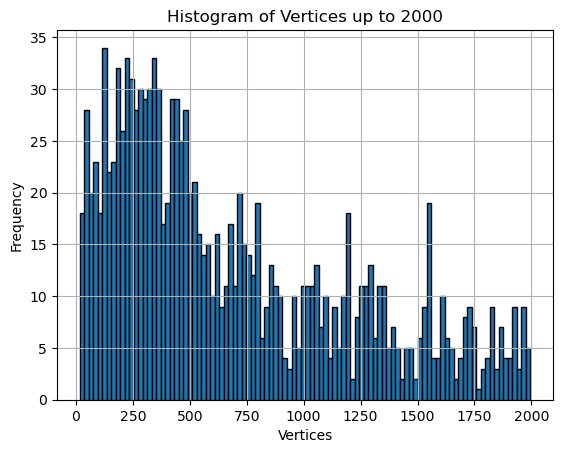

In [13]:
import matplotlib.pyplot  as plt
# Create a histogram
plt.hist(df[df['Vertices'] < 2000]['Vertices'], bins=100, edgecolor='k')  # Adjust the number of bins as needed
plt.xlabel('Vertices')
plt.ylabel('Frequency')
plt.title('Histogram of Vertices up to 2000')
plt.grid(True)

# Display the histogram
plt.show()

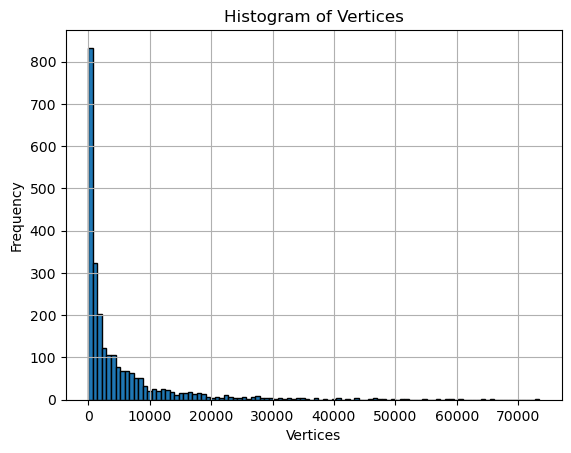

In [14]:
import matplotlib.pyplot  as plt
# Create a histogram
plt.hist(df['Vertices'], bins=100, edgecolor='k')  # Adjust the number of bins as needed
plt.xlabel('Vertices')
plt.ylabel('Frequency')
plt.title('Histogram of Vertices')
plt.grid(True)

# Display the histogram
plt.show()

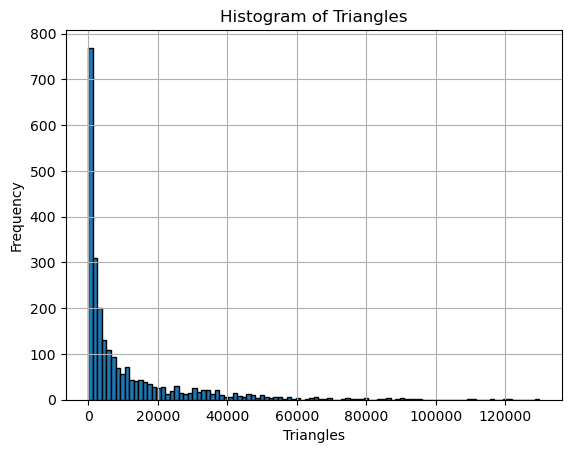

In [15]:
# Create a histogram
plt.hist(df["Triangles"], bins=100, edgecolor='k')  # Adjust the number of bins as needed
plt.xlabel('Triangles')
plt.ylabel('Frequency')
plt.title('Histogram of Triangles')
plt.grid(True)

# Display the histogram
plt.show()

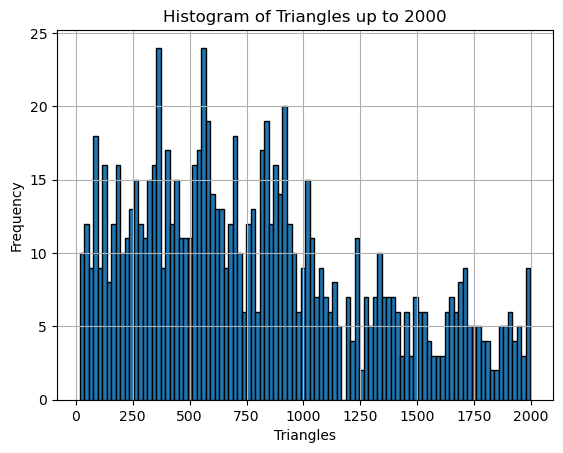

In [16]:
import matplotlib.pyplot  as plt
# Create a histogram
plt.hist(df[df['Triangles'] < 2000]["Triangles"], bins=100, edgecolor='k')  # Adjust the number of bins as needed
plt.xlabel('Triangles')
plt.ylabel('Frequency')
plt.title('Histogram of Triangles up to 2000')
plt.grid(True)

# Display the histogram
plt.show()

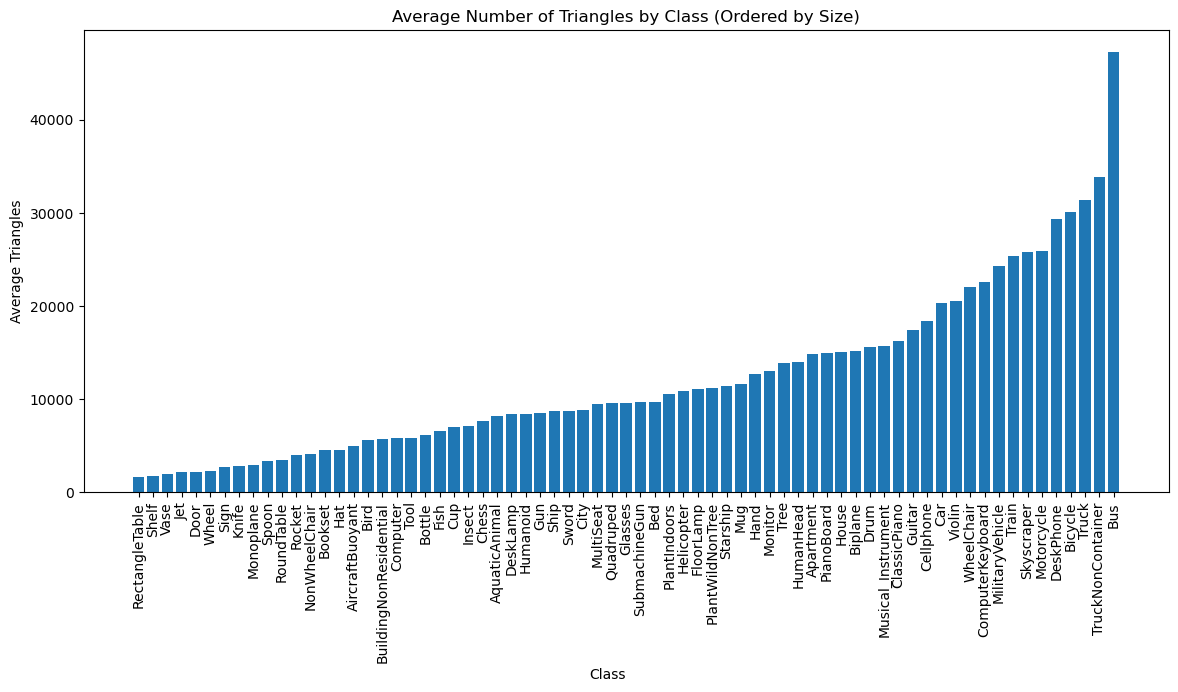

In [17]:
average_triangles = df.groupby('Class')['Triangles'].mean().reset_index()

# Sort the DataFrame by average Triangles in descending order
average_triangles = average_triangles.sort_values(by='Triangles', ascending=True)


# Create a bar chart with angled x-axis labels
plt.figure(figsize=(14, 6))
plt.bar(average_triangles['Class'], average_triangles['Triangles'])
plt.xlabel('Class', ha='right')  # Angle the x-axis labels
plt.xticks(rotation=90)
plt.ylabel('Average Triangles')
plt.title('Average Number of Triangles by Class (Ordered by Size)')
plt.show()

### Outliers

In [18]:
highVertexDf = df[df['Vertices'] > 50000]
highVertexDf

,Class,Filename,Vertices,Triangles,Filepath
100,Bicycle,D00462.obj,56754,111471,./database/Bicycle\D00462.obj
143,Biplane,m1120.obj,65722,129881,./database/Biplane\m1120.obj
366,Car,m1510.obj,54710,109357,./database/Car\m1510.obj
396,Car,m1544.obj,60326,116378,./database/Car\m1544.obj
457,Chess,m1595.obj,60667,121343,./database/Chess\m1595.obj
944,Helicopter,m1308.obj,58392,116773,./database/Helicopter\m1308.obj
1705,PlantIndoors,D00080.obj,64126,34887,./database/PlantIndoors\D00080.obj
1791,PlantWildNonTree,m985.obj,50833,88945,./database/PlantWildNonTree\m985.obj
2095,Skyscraper,D00058.obj,73440,53448,./database/Skyscraper\D00058.obj
2103,Skyscraper,D00520.obj,51626,52041,./database/Skyscraper\D00520.obj


In [19]:
highTrianglesDf = df[df['Triangles'] > 100000]
highTrianglesDf

,Class,Filename,Vertices,Triangles,Filepath
100,Bicycle,D00462.obj,56754,111471,./database/Bicycle\D00462.obj
143,Biplane,m1120.obj,65722,129881,./database/Biplane\m1120.obj
366,Car,m1510.obj,54710,109357,./database/Car\m1510.obj
396,Car,m1544.obj,60326,116378,./database/Car\m1544.obj
406,Car,m1556.obj,35131,119540,./database/Car\m1556.obj
457,Chess,m1595.obj,60667,121343,./database/Chess\m1595.obj
944,Helicopter,m1308.obj,58392,116773,./database/Helicopter\m1308.obj


In [20]:
lowVertexDf = df[df['Vertices'] < 50]
lowVertexDf

,Class,Filename,Vertices,Triangles,Filepath
45,AquaticAnimal,m59.obj,44,1680,./database/AquaticAnimal\m59.obj
201,Bird,m43.obj,41,54,./database/Bird\m43.obj
268,BuildingNonResidential,m390.obj,40,45,./database/BuildingNonResidential\m390.obj
270,BuildingNonResidential,m392.obj,33,80,./database/BuildingNonResidential\m392.obj
531,Computer,D01071.obj,29,43,./database/Computer\D01071.obj
535,Computer,D01085.obj,46,76,./database/Computer\D01085.obj
538,Computer,D01102.obj,28,30,./database/Computer\D01102.obj
544,Computer,m1765.obj,28,30,./database/Computer\m1765.obj
545,Computer,m1766.obj,29,43,./database/Computer\m1766.obj
547,Computer,m1769.obj,46,76,./database/Computer\m1769.obj


In [21]:
lowTrianglesDf = df[df['Triangles'] < 50]
lowTrianglesDf

,Class,Filename,Vertices,Triangles,Filepath
268,BuildingNonResidential,m390.obj,40,45,./database/BuildingNonResidential\m390.obj
531,Computer,D01071.obj,29,43,./database/Computer\D01071.obj
538,Computer,D01102.obj,28,30,./database/Computer\D01102.obj
544,Computer,m1765.obj,28,30,./database/Computer\m1765.obj
545,Computer,m1766.obj,29,43,./database/Computer\m1766.obj
665,Door,D01121.obj,16,16,./database/Door\D01121.obj
668,Door,D01139.obj,31,29,./database/Door\D01139.obj
676,Door,D01194.obj,18,18,./database/Door\D01194.obj
678,Door,m1708.obj,16,16,./database/Door\m1708.obj
990,House,m423.obj,35,48,./database/House\m423.obj


In [22]:
df[df["Class"] == "Spoon"]

,Class,Filename,Vertices,Triangles,Filepath
2114,Spoon,D00014.obj,748,4485,./database/Spoon\D00014.obj
2115,Spoon,D00085.obj,575,3444,./database/Spoon\D00085.obj
2116,Spoon,D00144.obj,243,1407,./database/Spoon\D00144.obj
2117,Spoon,D00157.obj,386,2499,./database/Spoon\D00157.obj
2118,Spoon,D00196.obj,756,4812,./database/Spoon\D00196.obj
2119,Spoon,D00338.obj,481,3021,./database/Spoon\D00338.obj
2120,Spoon,D00422.obj,109,528,./database/Spoon\D00422.obj
2121,Spoon,D00474.obj,72,363,./database/Spoon\D00474.obj
2122,Spoon,D00497.obj,144,852,./database/Spoon\D00497.obj
2123,Spoon,D00517.obj,481,2697,./database/Spoon\D00517.obj


### Resampling outliers

We want all objects to have a similar amount of Vertices, be centered, scaled to a unit cube and rotated by their eigenvectors in order to be used for the following steps. 

In [23]:
import pymeshlab as pml

In [24]:
def translate_to_center(mesh):
    """
    Translate the mesh so that center is at the coordinate-frame origin.
    """
    mesh.translate(-mesh.get_center())
    return mesh

In [25]:
def scale_unitcube(mesh):
    """
    Scale mesh to fit in a unit-sized cube.
    """
    center = mesh.get_center()

    #test is mesh is centered at origin
    if center[0] > 0.001 or center[1] > 0.001 or center[2] > 0.001:
        raise ValueError(
            f'Mesh must be centered at origin'
        )
    factor = 1 / max(mesh.get_max_bound() - mesh.get_min_bound())
    print("Factor: ", factor)
    mesh.scale(factor, center)
    return mesh

In [171]:
viz_mesh("./resampled4/DeskLamp/D00797.obj")

In [27]:
def get_eigen_vectors(mesh):
    # Load the mesh with open3d
    

    # Obtain numpy array containing the mesh's vertex positions.
    # Note: modifying values in the array will also change the corresponding vertex
    # positions in the mesh object
    vertices = np.asarray(mesh.vertices)

    # Compute barycenter
    barycenter = np.mean(vertices, axis=0)

    # Align mesh and vertices to origin
    vertices -= barycenter

    # Compute covariance matrix on vertices array
    cov = np.cov(vertices.transpose())

    # Compute eigen vectors and eigen values of covariance matrix
    # The eigen vectors are the columns of the returned 2d-array
    eigenvalues, eigenvectors = np.linalg.eig(cov)

    # Order the eigenvectors according to the magnitude of their corresponding eigen value
    # (from largest to smallest)
    eigencombined = [(eigenvalues[i], eigenvectors[:, i]) for i in range(3)]
    eigencombined.sort(key=lambda x:x[0], reverse=True)
    eigenvectors = [item[1] for item in eigencombined]
    eigenvalues = [item[0] for item in eigencombined]

    # Replace the minor eigen vector with cross product of major and medium (to enforce right-handed reference frame)
    eigenvectors.pop(2)
    eigenvectors.append(np.cross(eigenvectors[0], eigenvectors[1]))

    eigvec_startpoint = np.zeros(3)
    eigvec_points = [eigvec_startpoint] + [vec for vec in eigenvectors]
    eigvec_line_indices = [[0, 1], [0, 2], [0, 3]]
    eigvec_lineset = o3d.geometry.LineSet(
        points=o3d.utility.Vector3dVector(eigvec_points),
        lines=o3d.utility.Vector2iVector(eigvec_line_indices),
    )

    # Add colors to the lines
    # Red, green, blue for major, 2nd-, and 3rd-largest eigen vectors, respectively. 
    line_colors = np.array([[255,0,0], [0,255,0], [0,0,255]])
    eigvec_lineset.colors = o3d.utility.Vector3dVector(line_colors)

    return eigenvectors, eigvec_lineset

In [28]:
import copy
def transform(mesh):
    eigen_vectors,_ = get_eigen_vectors(mesh)
   
    mesh_r = copy.deepcopy(mesh)

    mesh_r.rotate(eigen_vectors, center=(0, 0, 0))

    """below this line is for visualisation"""
    # Display the mesh including a world axis system.

    # Create the endpoints of each line. Each line is unit-length.
    # For the world axes, the origin is shared by all lines. So we have 4 endpoints in total
    line_endpoints = [
        [0, 0, 0],
        [1, 0, 0],
        [0, 1, 0],
        [0, 0, 1]
    ]
    

    # List of indices into the 'line_endpoints' list, which describes which endpoints form which line
    line_indices = [[0, 1], [0, 2], [0, 3]]

    # Create a line set from the endpoints and indices
    world_axes = o3d.geometry.LineSet(
        points=o3d.utility.Vector3dVector(line_endpoints),
        lines=o3d.utility.Vector2iVector(line_indices),
    )
    # world_axes = o3d.geometry.TriangleMesh.create_coordinate_frame() 

    # Render the line set and the mesh
    # o3d.visualization.draw_geometries([ mesh_r, world_axes], width=1280, height=720, mesh_show_wireframe=True)
    return mesh_r

mesh = o3d.io.read_triangle_mesh("./database/Rocket/D00015.obj")
transform(mesh)

TriangleMesh with 88 points and 156 triangles.

In [29]:
#flip
def flip_mesh(mesh):
    mass = [0, 0, 0]
    for triangle in mesh.triangles:
        center = [0, 0, 0]
        for v in triangle:
            vertex = mesh.vertices[v]
            center += vertex
        center = center / 3
        
        for i, C in enumerate(center):
            mass[i] += np.sign(C) * (C * C)
    flip_matrix = np.asarray(
        [[1, 0, 0, 0],
         [0, 1, 0, 0],
         [0, 0, 1, 0],
         [0, 0, 0, 1]]
    )
    for i, C in enumerate(mass):
        if C > 0:
            print("flipped")
            flip_matrix[i, i] = -1

    return mesh.transform(flip_matrix)

In [30]:
def remesh_increase(mesh, targetlen=0.02, iterations=3):
    # print(f"Vertices before: {mesh.current_mesh().vertex_number()}, Faces before: {mesh.current_mesh().face_number()}")
    # print(f"Refining mesh ({iterations} iterations)... ")
    mesh.meshing_isotropic_explicit_remeshing(
        targetlen=pml.AbsoluteValue(targetlen), iterations=iterations)

    vAfter = mesh.current_mesh().vertex_number()
    fAfter = mesh.current_mesh().face_number()
    # print(f"Vertices after: {vAfter}, Faces after: {fAfter}")
    return mesh

In [137]:
def copymesh(mesh):
    mesh.save_current_mesh("tmp.obj")
    newmesh = pml.MeshSet()
    newmesh.load_new_mesh("tmp.obj")
    return newmesh

In [178]:
def remesh(mesh, classname, filename, target_vertices=7000, factor=0.2):
    # mesh = pml.MeshSet()
    # mesh.load_new_mesh(mesh_path)
    newfolderpath = "./resampledTEST"
    print(f"Vertices before: {mesh.current_mesh().vertex_number()}, Faces before: {mesh.current_mesh().face_number()}")

    # if mesh.current_mesh().vertex_number() < target_vertices * (1-factor):
    count = 0

    targetlen = 0.02
    while mesh.current_mesh().vertex_number() < target_vertices* (1-factor) and count < 5:#not in range(int(target_vertices*(1-factor)), int(target_vertices*(1+factor))):
        count += 1
        remesh_increase(mesh, targetlen=targetlen)
        targetlen //= 2


    # meshcopy = o3d_to_pml(copy.deepcopy(pml_to_o3d(mesh)))
    # meshcopy = mesh
    meshcopy = copymesh(mesh)

    count = 0
    factor2 = 1
    while meshcopy.current_mesh().vertex_number() not in range(int(target_vertices* (1-factor)),int(target_vertices* (1+factor))) and count < 15:
        count += 1
        meshcopy.meshing_decimation_quadric_edge_collapse(targetfacenum=int(factor2 * int(target_vertices*(mesh.current_mesh().face_number()/mesh.current_mesh().vertex_number())))) #Uses the ratio of Triangles/Vertices to determine the target triangles

        if meshcopy.current_mesh().vertex_number() < target_vertices* (1-factor):
            factor2 *= 1.1
        elif meshcopy.current_mesh().vertex_number() > target_vertices* (1+factor):
            factor2 *= 0.9
        else:
            mesh = meshcopy
        # meshcopy = o3d_to_pml(copy.deepcopy(pml_to_o3d(mesh)))
        # meshcopy = mesh
        meshcopy = copymesh(mesh)

    newFilePath = f"{newfolderpath}/{classname}/{filename}"

    if not os.path.exists(f"{newfolderpath}/{classname}"):
        os.makedirs(f"{newfolderpath}/{classname}")

    mesh = o3d_to_pml(scale_unitcube(flip_mesh(transform(pml_to_o3d(mesh)))))
    mesh.save_current_mesh(newFilePath)

    vAfter = mesh.current_mesh().vertex_number()
    fAfter = mesh.current_mesh().face_number()
    print(f"Vertices after: {vAfter}, Faces after: {fAfter}")
    return mesh, vAfter, fAfter, newFilePath
            

Runs through all the folders and computes the transformations and remeshing on each object, which is saved in the resampled folder. If theres an error at converting it is saved in log.txt

In [26]:
run_resampling = False


target_vertices = 7000
factor = 0.2

if run_resampling:

    dbpath = r"./database/"
    for class_folder in os.listdir(dbpath):
        # Construct the full path to the subfolder
        class_folder_path = os.path.join(dbpath, class_folder)
        
        # Check if the item in the directory is a directory (to skip files)
        if os.path.isdir(class_folder_path):
            # Assuming the class folder name is the class name
            class_name = class_folder
            
            # Iterate through .obj files in the subfolder
            for obj_file_path in glob.glob(os.path.join(class_folder_path, '*.obj')):
                log = open("./log3.txt", "a")

                try:
                    mesh = pml.MeshSet()
                    mesh.load_new_mesh(obj_file_path)
                    mesh = o3d_to_pml(translate_to_center(pml_to_o3d(mesh)))
                    _,vAfter,_,_ = remesh(mesh, class_name, obj_file_path.split("\\")[-1], target_vertices, factor)
                    if vAfter not in range(int(target_vertices* (1-factor)),int(target_vertices* (1+factor))):
                        print(f"Object outside of Vertex range {obj_file_path}, Vertices = {vAfter}", file=log)

                except:
                    print(f"Failed to convert {obj_file_path}", file=log)
                log.close()


Vertices before: 8761, Faces before: 16960
flipped
flipped
Factor:  1.04627930607378


Create a new dataframe with the transformed data

In [32]:
run_resample_to_df = True
if run_resample_to_df:
    dbpath = r"./resampled3/"
    mesh_data2 = []
    for class_folder in os.listdir(dbpath):
        # Construct the full path to the subfolder
        class_folder_path = os.path.join(dbpath, class_folder)

        # Check if the item in the directory is a directory (to skip files)
        if os.path.isdir(class_folder_path):
            # Assuming the class folder name is the class name
            class_name = class_folder

            # Iterate through .obj files in the subfolder
            for obj_file_path in glob.glob(os.path.join(class_folder_path, '*.obj')):
                
                mesh = o3d.io.read_triangle_mesh(obj_file_path)
                filename = obj_file_path.split("\\")[-1]
                vertices = np.asarray(mesh.vertices)
                triangles = np.asarray(mesh.triangles)
                filepath = class_folder_path
                mesh_data2.append([class_name, filename, len(vertices), len(triangles), obj_file_path])

                print(f"Class: {class_name}, Vertices: {len(vertices)}, Triangles: {len(triangles)}")
    df2 = pd.DataFrame(mesh_data2, columns=["Class", "Filename", "Vertices", "Triangles", "Filepath"])
    df2.to_pickle("dataframe_resampled3.pkl")
    df2

Class: Bus, Vertices: 2058, Triangles: 11481
Class: Bus, Vertices: 1835, Triangles: 13935
Class: Bus, Vertices: 1981, Triangles: 11742
Class: Bus, Vertices: 1983, Triangles: 12084
Class: Bus, Vertices: 2200, Triangles: 8409
Class: Bus, Vertices: 1927, Triangles: 11502
Class: Bus, Vertices: 1978, Triangles: 12699
Class: Bus, Vertices: 1893, Triangles: 13524
Class: Bus, Vertices: 2244, Triangles: 10971
Class: Bus, Vertices: 2060, Triangles: 12294
Class: Bus, Vertices: 2071, Triangles: 10740
Class: Bus, Vertices: 2086, Triangles: 13794
Class: Bus, Vertices: 1934, Triangles: 12693
Class: Bus, Vertices: 1853, Triangles: 14028
Class: Bus, Vertices: 2007, Triangles: 11895
Class: Bus, Vertices: 1880, Triangles: 14244
Class: Bus, Vertices: 2040, Triangles: 12105
Class: Bus, Vertices: 2125, Triangles: 11304
Class: Bus, Vertices: 1978, Triangles: 11526
Class: Bus, Vertices: 1944, Triangles: 12873
Class: BuildingNonResidential, Vertices: 2172, Triangles: 3595
Class: BuildingNonResidential, Vertice

In [32]:
df2 = pd.read_pickle("dataframe_resampled_large.pkl")


### Statistics after resampling

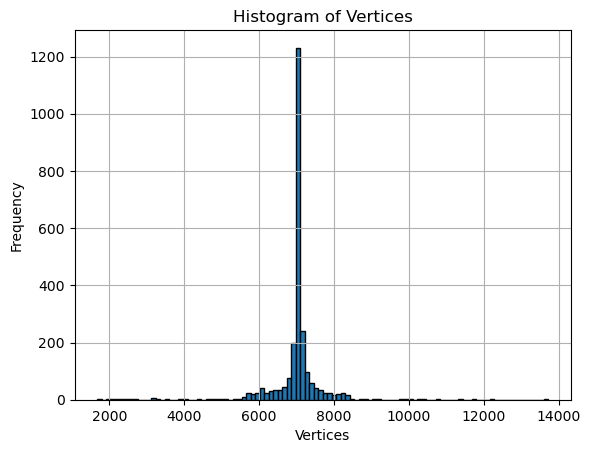

In [33]:
# Create a histogram
plt.hist(df2['Vertices'], bins=100, edgecolor='k')  # Adjust the number of bins as needed
plt.xlabel('Vertices')
plt.ylabel('Frequency')
plt.title('Histogram of Vertices')
plt.grid(True)

# Display the histogram
plt.show()

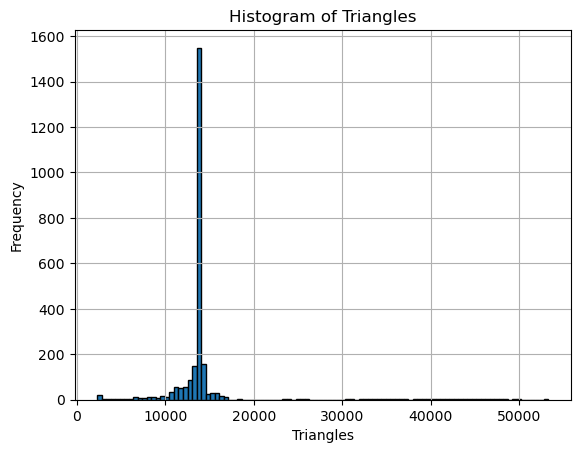

In [34]:
# Create a histogram
plt.hist(df2['Triangles'], bins=100, edgecolor='k')  # Adjust the number of bins as needed
plt.xlabel('Triangles')
plt.ylabel('Frequency')
plt.title('Histogram of Triangles')
plt.grid(True)

# Display the histogram
plt.show()

In [35]:
"Min. Vertices:", df2["Vertices"].min(), "Max. Vertices:", df2["Vertices"].max(), "Avg. Vertices", df2["Vertices"].mean()

('Min. Vertices:',
 1676,
 'Max. Vertices:',
 13723,
 'Avg. Vertices',
 6984.318274318274)

In [36]:
"Min. Triangles:", df2["Triangles"].min(), "Max. Triangles:", df2["Triangles"].max(), "Avg. Triangles", df2["Triangles"].mean()

('Min. Triangles:',
 2326,
 'Max. Triangles:',
 53259,
 'Avg. Triangles',
 14124.189662189663)

In [37]:
pathh="./database/AquaticAnimal\m56.obj"
o3d.io.read_triangle_mesh(pathh)

TriangleMesh with 5814 points and 10893 triangles.

In [38]:
viz_mesh(pathh)

In [69]:
df2

,Class,Filename,Vertices,Triangles,Filepath
0,Bus,D00446.obj,2058,11481,./resampled3/Bus\D00446.obj
1,Bus,D00114.obj,1835,13935,./resampled3/Bus\D00114.obj
2,Bus,D00084.obj,1981,11742,./resampled3/Bus\D00084.obj
3,Bus,D00516.obj,1983,12084,./resampled3/Bus\D00516.obj
4,Bus,D00483.obj,2200,8409,./resampled3/Bus\D00483.obj
...,...,...,...,...,...
2476,AquaticAnimal,m57.obj,2067,3843,./resampled3/AquaticAnimal\m57.obj
2477,AquaticAnimal,m56.obj,2048,3747,./resampled3/AquaticAnimal\m56.obj
2478,AquaticAnimal,m55.obj,2016,3800,./resampled3/AquaticAnimal\m55.obj
2479,AquaticAnimal,m54.obj,1986,3729,./resampled3/AquaticAnimal\m54.obj


In [45]:
df[df["Filepath"] == "./database/Biplane\D00246.obj"]

,Class,Filename,Vertices,Triangles,Filepath
125,Biplane,D00246.obj,5022,9353,./database/Biplane\D00246.obj


In [47]:
viz_mesh("./database/Rocket\D00564.obj")

In [46]:
viz_mesh("./resampled4/Rocket\D00564.obj")

In [39]:
df2[df2['Vertices'] < 5500]

,Class,Filename,Vertices,Triangles,Filepath
161,Biplane,D00178.obj,4001,5034,./resampled4/Biplane\D00178.obj
163,Biplane,D00246.obj,3161,4718,./resampled4/Biplane\D00246.obj
291,Apartment,D00921.obj,4915,4353,./resampled4/Apartment\D00921.obj
294,Apartment,D00310.obj,4596,4588,./resampled4/Apartment\D00310.obj
461,Tree,D00777.obj,4808,4406,./resampled4/Tree\D00777.obj
586,Sword,D00066.obj,5336,8024,./resampled4/Sword\D00066.obj
686,Skyscraper,D00058.obj,4082,5075,./resampled4/Skyscraper\D00058.obj
687,Skyscraper,D00059.obj,4625,3799,./resampled4/Skyscraper\D00059.obj
690,Skyscraper,D00126.obj,5001,6708,./resampled4/Skyscraper\D00126.obj
692,Skyscraper,D00259.obj,3953,8039,./resampled4/Skyscraper\D00259.obj


In [41]:
df2[df2['Vertices'] > 8500]

,Class,Filename,Vertices,Triangles,Filepath
447,Tree,D00096.obj,9785,4713,./resampled4/Tree\D00096.obj
449,Tree,D00221.obj,11754,7204,./resampled4/Tree\D00221.obj
450,Tree,D00223.obj,10247,6497,./resampled4/Tree\D00223.obj
453,Tree,D00393.obj,8721,5905,./resampled4/Tree\D00393.obj
454,Tree,D00439.obj,11335,5415,./resampled4/Tree\D00439.obj
456,Tree,D00479.obj,12200,8811,./resampled4/Tree\D00479.obj
457,Tree,D00533.obj,9815,3895,./resampled4/Tree\D00533.obj
458,Tree,D00573.obj,13723,6995,./resampled4/Tree\D00573.obj
460,Tree,D00727.obj,8902,5043,./resampled4/Tree\D00727.obj
464,Tree,D00911.obj,9848,5560,./resampled4/Tree\D00911.obj


In [39]:
subpath = "ComputerKeyboard\D00676.obj"
df[df["Filepath"]== "./database/"+subpath]["Triangles"]/df[df["Filepath"]== "./database/"+subpath]["Vertices"], df2[df2["Filepath"]== "./resampled2/"+subpath]["Triangles"]/df2[df2["Filepath"]== "./resampled2/"+subpath]["Vertices"]

(571    5.397059
 dtype: float64,
 Series([], dtype: float64))

In [40]:
viz_mesh("./resampled2/Bus\D00114.obj")

Lets view two objects, before and after the transformation:

In [22]:
viz_mesh("./database/Rocket/D00015.obj")

In [23]:
viz_mesh("./resampled/Rocket/D00015.obj")

In [40]:
df2

,Class,Filename,Vertices,Triangles,Filepath
0,AircraftBuoyant,m1337.obj,1840,3600,./resampled2/AircraftBuoyant\m1337.obj
1,AircraftBuoyant,m1338.obj,1852,3600,./resampled2/AircraftBuoyant\m1338.obj
2,AircraftBuoyant,m1339.obj,1878,6173,./resampled2/AircraftBuoyant\m1339.obj
3,AircraftBuoyant,m1340.obj,2255,4414,./resampled2/AircraftBuoyant\m1340.obj
4,AircraftBuoyant,m1341.obj,1914,3792,./resampled2/AircraftBuoyant\m1341.obj
...,...,...,...,...,...
2466,WheelChair,D00687.obj,1854,3600,./resampled2/WheelChair\D00687.obj
2467,WheelChair,D00720.obj,1990,3599,./resampled2/WheelChair\D00720.obj
2468,WheelChair,D00782.obj,1973,3600,./resampled2/WheelChair\D00782.obj
2469,WheelChair,D00821.obj,1854,3600,./resampled2/WheelChair\D00821.obj


In [52]:
mesh

TriangleMesh with 1852 points and 3600 triangles.

In [51]:
path = "./resampled2/AircraftBuoyant\m1338.obj"
mesh = o3d.io.read_triangle_mesh(path)
get_eigen_vectors(mesh)

([array([-1.00000000e+00,  1.27818207e-06, -2.13804210e-07]),
  array([ 1.27818215e-06,  1.00000000e+00, -3.72644096e-07]),
  array([ 2.13803734e-07, -3.72644370e-07, -1.00000000e+00])],
 LineSet with 3 lines.)

In [140]:
path = "./database/Car\D00405.obj"
mesh = pml.MeshSet()
mesh.load_new_mesh(path)
remesh(mesh, path.split("/")[2].split("\\")[0], path.split("\\")[1], target_vertices=7000, factor=0.1)

Vertices before: 62279, Faces before: 24552
flipped
flipped
Factor:  0.5558383489933066
Vertices after: 6744, Faces after: 7156


(<pymeshlab.pmeshlab.MeshSet at 0x289ca2253f0>,
 6744,
 7156,
 './resampledTEST/Car/D00405.obj')

Vertices before: 6361, Faces before: 8349
flipped
flipped
flipped
Factor:  0.9995067004816255
Vertices after: 6361, Faces after: 8349


(<pymeshlab.pmeshlab.MeshSet at 0x289d33decb0>,
 6361,
 8349,
 './resampledTEST/Car/D00405.obj')

In [159]:
path = "./database/Biplane\D00246.obj"
compare_mesh(path, offset=(1,0,0), db1="./database/", db2 = "./resampled4/", vis_option="world_axes")

In [163]:
o3d.io.read_triangle_mesh(path)

TriangleMesh with 5022 points and 9353 triangles.

In [144]:
path.replace("resampled4","database")

'./database/Car\\D00405.obj'

In [150]:
df[df["Class"]=="Biplane"]

,Class,Filename,Vertices,Triangles,Filepath
121,Biplane,D00069.obj,3242,6326,./database/Biplane\D00069.obj
122,Biplane,D00132.obj,287,348,./database/Biplane\D00132.obj
123,Biplane,D00178.obj,4566,8057,./database/Biplane\D00178.obj
124,Biplane,D00199.obj,2584,3764,./database/Biplane\D00199.obj
125,Biplane,D00246.obj,5022,9353,./database/Biplane\D00246.obj
126,Biplane,D00276.obj,512,916,./database/Biplane\D00276.obj
127,Biplane,D00277.obj,22419,41567,./database/Biplane\D00277.obj
128,Biplane,D00320.obj,9723,17476,./database/Biplane\D00320.obj
129,Biplane,D00373.obj,5941,12536,./database/Biplane\D00373.obj
130,Biplane,D00410.obj,2167,4254,./database/Biplane\D00410.obj


In [154]:
df[df["Vertices"] < 200]

,Class,Filename,Vertices,Triangles,Filepath
6,AircraftBuoyant,m1343.obj,178,344,./database/AircraftBuoyant\m1343.obj
45,AquaticAnimal,m59.obj,44,1680,./database/AquaticAnimal\m59.obj
60,AquaticAnimal,m74.obj,162,336,./database/AquaticAnimal\m74.obj
65,AquaticAnimal,m79.obj,166,226,./database/AquaticAnimal\m79.obj
200,Bird,m42.obj,116,265,./database/Bird\m42.obj
...,...,...,...,...,...
2411,Vase,m533.obj,32,68,./database/Vase\m533.obj
2413,Vase,m535.obj,176,320,./database/Vase\m535.obj
2459,Wheel,m746.obj,80,128,./database/Wheel\m746.obj
2460,Wheel,m747.obj,128,252,./database/Wheel\m747.obj


In [ ]:
for path in df2[df2['Vertices'] < 5500]["Filepath"]:
    print(path)
    path = path.replace("resampled4","database")
    print(path)
    mesh = pml.MeshSet()            # why does pml load a mesh with different vertex number?
    mesh.load_new_mesh(path)
    remesh(mesh, path.split("/")[2].split("\\")[0], path.split("\\")[1], target_vertices=7000, factor=0.1)

In [166]:
for path in df2[df2['Vertices'] < 5500]["Filepath"]:
    print(path)
    path = path.replace("resampled4","database")
    print(path)
    mesh = o3d_to_pml(o3d.io.read_triangle_mesh(path))
    remesh(mesh, path.split("/")[2].split("\\")[0], path.split("\\")[1], target_vertices=7000, factor=0.1)

./resampled4/Biplane\D00178.obj
./database/Biplane\D00178.obj
Vertices before: 4566, Faces before: 7609
flipped
flipped
Factor:  0.7107883726420045
Vertices after: 7052, Faces after: 12519
./resampled4/Biplane\D00246.obj
./database/Biplane\D00246.obj
Vertices before: 5022, Faces before: 9353
flipped
Factor:  0.5036997218688845
Vertices after: 7053, Faces after: 13517
./resampled4/Apartment\D00921.obj
./database/Apartment\D00921.obj
Vertices before: 6689, Faces before: 7983
Factor:  0.6158554411849801
Vertices after: 6689, Faces after: 7983
./resampled4/Apartment\D00310.obj
./database/Apartment\D00310.obj
Vertices before: 5934, Faces before: 9480
flipped
Factor:  0.5642176406016458
Vertices after: 7577, Faces after: 12799
./resampled4/Tree\D00777.obj
./database/Tree\D00777.obj
Vertices before: 21856, Faces before: 13758


KeyboardInterrupt: 